# answers, week 08: the adventure of the chimeric reads

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special

rng = np.random.default_rng(18090212)

%matplotlib inline

## the HMM is given to us

In [2]:
def make_hmm():
     p = 1/200   # Mean seg length of 100. 

     t = np.array([[ 0.0, 1/2,   1/2 ],     # state 0 = start/end
                   [ p, 1-2*p,     p ],     # state 1 = AluminumJesus
                   [ p,     p, 1-2*p ]] )   # state 2 = T4

     e = np.array([[   1/4,   1/4,   1/4,   1/4 ],    # unused; start/end state doesn't emit
                   [ 0.166, 0.334, 0.334, 0.166 ],    # AluminumJesus residue composition
                   [ 0.323, 0.177, 0.177, 0.323 ]] )  # T4 residue composition
     return (t,e)

## 1. Implement the standard HMM algorithms

### first some conventions

For all of the code below, some of the key pieces of data always follow these conventions:

`dsq` is an observed sequence. It is an array indexed i = 0, 1 ... L, with residues at 1...L and an unused value at position that I set to -1. Boundary conditions in the dynamic programming calculations (such as row 0 in a Viterbi or Forward calculation) make it convenient to index into the sequence as 1..L instead of 0..L-1. The values at `dsq[i]` for i=1..L are digitized residues 0|1|2|3 representing A|C|G|T. I assume that DNA sequences in the problem will have no ambiguity codes, only canonical A|C|G|T residues. dsq corresponds to $x$ in the math notation in lecture notes. 

`hmm` is an HMM. It is a tuple `(t, e)`, where `t` is the transition probability matrix and `e` is the emission probability matrix. `t[k][j]` is an array of shape (M+1,M+1), with main states indexed k = 1..M and a special begin/end state at k=0. `e[k][a]` has shape (M+1, A), where A is the alphabet size (here, 4 for DNA). Rows `t[k]` and `e[k]` are probability distributions that sum to one.

`loghmm` is an HMM where I've pre-converted all the probability parameters to log probabilities `(tsc, esc)`. This is an optimization that saves having to do a bunch of `np.log` calls in the inner loop of dynamic programming calculations.

`pi` is a state path. It is an array indexed i = 0, 1..L, L+1. `pi[0] = pi[L+1] = 0`, the start and end state 0. At i=1..L, `pi[i]` is the state index k that emitted (is assigned/aligned to) observed residue at i. An optimal Viterbi state path is `vpi`. An optimal posterior decoding path is `dpi`.



Having said that: I kept getting confused about how I was using `M`, the size of an HMM. I use M to mean the number of main states in the HMM, not counting the special begin/end state 0. Finally I wrote a little function to always get M consistently, and A while I'm at it. Then I did the same sort of thing for `dsq` and `pi`.

In [3]:
def hmm_shape(hmm):
    """Return (M,A), the relevant dimensions of the HMM.

    Because of the special state 0 at begin/end, the shapes of the t and e parameter arrays are 
    (M+1,M+1) and (M+1,A). Making this little helper function for getting M,A consistently 
    helps reduce my off-by-one errors and confusion about how I'm using the size M. M is the number
    of main states in the HMM, not counting state 0.
    
    This also works for a loghmm, because it doesn't look at the parameters at all, only the shape of their arrays.
    """
    (r,c) = hmm[1].shape   # shape of the emission matrix tells us both M and A
    return (r-1,c)

def dsq_len(dsq):
    """Return L, given digital sequence dsq.
    """
    return len(dsq)-1   # not counting the sentinel at 0

def pi_len(pi):
    """Return L, given state path pi.
    """
    return len(pi)-2

And here's a function for converting my hmm to log probabilities.

In [4]:
def logify(hmm):
    (t, e) = hmm
    tsc    = np.copy(t)
    esc    = np.copy(e)

    tsc[tsc == 0] = -np.inf
    tsc[tsc > 0]  = np.log(tsc[tsc>0])
    esc[esc == 0] = -np.inf
    esc[esc > 0]  = np.log(esc[esc>0])

    return (tsc,esc)

### Now the HMM algorithms

In [5]:
def Viterbi(dsq, loghmm):
    """Align HMM to a sequence using the Viterbi algorithm.

    Input:
    dsq     digitized sequence 
    loghmm  HMM, with parameters as log probs

    Output: 
    logP    log P(x,vpi | HMM)
    vpi     optimal (Viterbi) state path
    """
    (tsc,esc) = loghmm
    (M,A)     = hmm_shape(loghmm)
    L         = dsq_len(dsq)
    
    V   = np.full((L+1,M+1), -np.inf)         # allocate (L+1) rows x (M+1) columns DP matrix initialized to -inf everywhere
    tau = np.full((L+1,M+1), -1).astype(int)  # and the same for the shadow traceback pointers
    vpi = np.zeros(L+2 ).astype(int)          # vpi[0,1..L,L+1] 

    # Initialization
    V[0,0] = 0.                   

    # Recursion
    for i in range(1,L+1):       # 1..L
        for k in range(1,M+1):   # 1..M   Left column V[i,0] was already initialized to -inf when we allocated V.
            v = [ V[i-1,j] + tsc[j,k] for j in range(M+1) ]   # look at all states j on previous row, including 0
            V[i,k]   = np.max(v) + esc[k,dsq[i]]
            tau[i,k] = np.argmax(v)

    # Termination
    v       = [ V[L,j] + tsc[j,0] for j in range(M+1) ]
    vpi[L]  = np.argmax(v)
    logP    = np.max(v)

    # Traceback
    for i in range(L, 0, -1):
        vpi[i-1] = tau[i,vpi[i]]

    return logP, vpi


In [6]:
def Forward(dsq, loghmm):
    """Align HMM to a sequence using the Forward algorithm.

    Returns:
    logP    log P(x | HMM)
    F       Forward DP matrix, shape (L+1,M+1)
    """
    (tsc, esc) = loghmm
    (M,A)      = hmm_shape(loghmm)
    L          = dsq_len(dsq)

    # Allocation
    F = np.full((L+1,M+1), -np.inf)

    # Initialization
    F[0,0] = 0.                   

    # Recursion
    for i in range(1,L+1):
        for k in range(1,M+1):                                           
            v       = [ F[i-1,j] + tsc[j,k] for j in range(M+1) ]    # need to look at j=0 only at i=1
            F[i,k] = special.logsumexp(v) + esc[k,dsq[i]]            # Forward replaces max() with logsumexp()

    # Termination
    v     = [ F[L,j] + tsc[j,0] for j in range(1,M+1) ]
    logP  = special.logsumexp(v)

    return logP, F


In [7]:
def Backward(dsq, loghmm):
    """Align HMM to a sequence using the Backward algorithm.

    Returns:
    logP       log P(x | HMM)
    B          Backward DP matrix, shape (L+1,M+1)
    """
    (tsc, esc) = loghmm
    (M,A)      = hmm_shape(loghmm)
    L          = dsq_len(dsq)
    
    # Allocation
    B = np.full((L+1,M+1), -np.inf)

    # Initialization
    for k in range(1,M+1):
        B[L,k] = tsc[k,0]      # Left column B[i,0] is already initialized to -inf 

    # Recursion
    for i in range(L-1, 0, -1):   # L-1 .. 1
        for k in range(1,M+1):
            v = [ B[i+1,j] + tsc[k,j] + esc[j,dsq[i+1]] for j in range(1,M+1)]   # don't need to look at j=0 on the way backwards
            B[i,k] = special.logsumexp(v)

    # Termination
    v = [ B[1,j] + tsc[0,j] + esc[j,dsq[1]] for j in range(1,M+1) ]
    logP = B[0,0] = special.logsumexp(v)
    return logP, B


In [8]:
def Decoding(F, B, logP):
    """Calculate the posterior decoding matrix, given Forward and Backward matrices.
    """
    (r,c) = F.shape
    L = r-1
    M = c-1

    D = np.zeros((L+1, M+1))
    D[0,0] = 1

    for i in range(1,L+1):
        for k in range(1,M+1):
            D[i,k] = np.exp(F[i,k] + B[i,k] - logP)
    return D
    
def Decoding_alt(F, B):
    return np.exp( F + B - B[0][0] )


In [9]:
def decode2path(D, threshold):
    """Use posterior decoding to infer a state path.

    Positions with a posterior prob < threshold are left uninferred, with dpi[i]=-1 being the flag for "uninferred".
    """
    (r,c) = D.shape
    L     = r-1
    M     = c-1

    dpi = [0]
    for i in range(1, L+1):
        if np.max(D[i]) >= threshold: dpi.append(int(np.argmax(D[i])))
        else:                         dpi.append(-1)
    dpi.append(0)
    return dpi


In [10]:
def compare_paths(true_pi, pi):
    """Calculate the accuracy of an inferred path, compared to ground truth.
    """

    L = pi_len(true_pi)
    nT = nF = 0
    for i in range(1, L+1):       # don't count begin/end state 0 toward accuracy
        if pi[i] == -1:           pass     # allow a "no call" in pi
        elif true_pi[i] == pi[i]: nT += 1
        else:                     nF += 1

    if nF == 0: acc = 1
    else:       acc = nT / (nT+nF)

    return nF, acc

That's all the functions we were asked to provide in part 1.

## 2. Do synthetic positive controls.

I'll need a function to generate a sequence $x$ from the HMM $\theta$. This samples from the distribution $P(x \mid \theta)$, and also from the distribution $P(x, \pi \mid \theta)$. I return both the sequence and its state path $\pi$, so I can use $\pi$ as ground truth in my positive controls.

In [11]:
def Generate(rng, hmm):
    """Sample a sequence from an HMM.

    Returns (dsq, pi), where pi is the state path.
    """    
    (t,e) = hmm
    (M,A) = hmm_shape(hmm)
    dsq   = [-1 ]   # dsq is indexed [1..L], with a -1 at 0
    pi    = [ 0 ]   # pi also indexed [1..L], with 0's at 0, L+1

    pi.append(int(rng.choice(np.arange(0,M+1), p=t[0])))   # t[0,0] = 0, so we won't sample a transition begin -> begin
    i  = 1
    while pi[i] != 0:
        dsq.append(int(rng.choice(np.arange(0,A),   p=e[pi[i]])))
        pi.append (int(rng.choice(np.arange(0,M+1), p=t[pi[i]])))
        i += 1
    return dsq, pi

I want to be able to visualize my results. I'll visualize the decoding matrix as a heat map, transposed so the longer L axis is horizontal. I'll visualize a path as a matrix too, with filled squares where the path is passing through, and use that to represent the true path, the Viterbi path, and the posterior decoding path. Where the inferred path is an error, I'll make that a different color (by setting the value to -1 instead of 1, and using a diverging colormap for my heatmap.


In [12]:
def path2matrix(pi, M, true_pi=None):
    L = pi_len(pi)
    X = np.zeros( (M+1, L+1) )

    if true_pi:
        for i in range(L+1):
            if pi[i] >= 0:
                if pi[i] == true_pi[i]: X[pi[i],i] = 1
                else:                   X[pi[i],i] = -1
    else:
        for i in range(L+1):
            if pi[i] >= 0: X[pi[i],i] = 1
    return X
    
def plot_matrix(ax, X):
    r,c = X.shape
    M,L = r-1,c-1

    ax.imshow(X, cmap='PiYG', vmin=-1, vmax=1, aspect='auto', interpolation='none')
    ax.set_yticks(np.arange(M+1))
    ax.spines[:].set_visible(False)
    ax.set_yticks(np.arange(1,M+1)-0.5, minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2, axis='y')	
    ax.set_xticks(np.arange(1,L+1)-0.5, minor=True)	# use minor ticks to create white grid
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1, axis='x')
    ax.tick_params(which="minor", bottom=False, left=False)	# don't show those minor ticks

def visualize(true_pi, D, vpi, dpi):
    L   = pi_len(true_pi)
    r,c = D.shape
    M   = c-1

    v_errors, v_acc = compare_paths(true_pi, vpi)
    d_errors, d_acc = compare_paths(true_pi, dpi)
    
    fig,axs = plt.subplots(4,1, layout='tight', figsize=(14, 5))

    axs[0].set_title('True path')
    axs[1].set_title('Decoding matrix')
    axs[2].set_title('Viterbi path   accuracy={:.3f}  {} errors'.format(v_acc, v_errors))
    axs[3].set_title('Posterior decoding path   accuracy={:.3f}  {} errors'.format(d_acc, d_errors))
 
    plot_matrix(axs[0], path2matrix(true_pi, M))
    plot_matrix(axs[1], D.T)
    plot_matrix(axs[2], path2matrix(vpi, M, true_pi=true_pi))
    plot_matrix(axs[3], path2matrix(dpi, M, true_pi=true_pi))
   

Now I'll make one notebook cell that runs one positive control:
- generates a synthetic sequence from the HMM
- runs Viterbi on it to get a Viterbi path (and log probability of that path)
- runs Forward, Backward, and Decoding to get a decoding matrix (and the log prob calculated by Forward and Backward)
- uses the decoding matrix to infer a path by posterior decoding
- compares the two inferred paths to the ground truth that was sampled
- visualizes the results

By re-running the cell, I can study how accurate my inferred paths are, as my synthetic sequences vary.

generated sequence length:       336
log P(x, vpi|HMM) from Viterbi:  -473.0
log P(x|HMM) from Forward:       -468.3
log P(x|HMM) from Backward:      -468.3


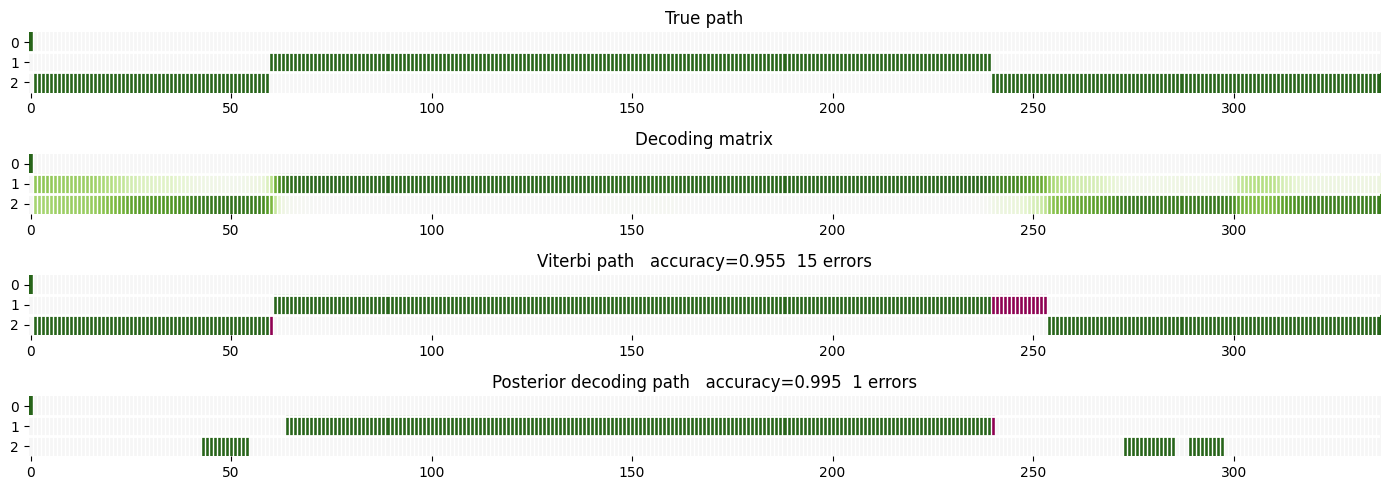

In [13]:
hmm            = make_hmm()
loghmm         = logify(hmm)
(dsq, true_pi) = Generate(rng, hmm)
L              = dsq_len(dsq)

(logPv, vpi) = Viterbi(dsq,  loghmm)
(logPf, F)   = Forward(dsq,  loghmm)
(logPb, B)   = Backward(dsq, loghmm)
D            = Decoding(F, B, logPf)

dpi          = decode2path(D, 0.9)

print('generated sequence length:       {}'.format(L))
print('log P(x, vpi|HMM) from Viterbi:  {:.1f}'.format(logPv))
print('log P(x|HMM) from Forward:       {:.1f}'.format(logPf))
print('log P(x|HMM) from Backward:      {:.1f}'.format(logPb))

visualize(true_pi, D, vpi, dpi)

### what trends do I observe in these accuracies?

1. The Decoding matrix shows that the inference is most uncertain around the point of a transition from one state to the other, which makes sense.
2. Consequently, most errors are at the edges of segments.
3. Long stretches in the same state are easier to infer accurately. When there's a short segment, it can be missed altogether, especially by the Viterbi path. (The Decoding matrix will usually show the uncertainty across a short segment.)
4. The posterior decoding path is more accurate, at the expense of leaving some positions uninferred. The posterior decoding matrix provides useful information about the confidence of an inferred hidden state.

### What's different about the generated sequences, compared to Moriarty's sequences?

Moriarty's sequences are always the same length (200), and always composed of exactly two segments, one segment from one genome and the other segment from the other genome.

The self-loop on each HMM state specifies a geometric distribution over segment lengths, and the HMM also specifies a geometric distribution over segment number. The mode of a geometric distribution P(x) for $x \geq 1$ is 1: the smallest value is most probable, and the probabilities decrease with $x$. Many generated sequences have one segment, and some have three or more segments, rather than having exactly two. 

This is a common issue with using HMMs: the "duration" of staying with one label can be difficult to model accurately. 

## 3. Analyze Moriarty's read sequences

Well, I'll need to input them, so:

In [14]:
def read_ground_truth(file):
    true_pi = []
    tbl     = []
    with open(file) as f:
        for line in f:
            if line[0] == '#': continue       # Skip comment lines
            fields  = line.split()            # Split into fields on whitespace
            if len(fields) != 5: continue
            seqname = fields[0]
            L       = int(fields[1])
            k       = int(fields[2])
            g0      = int(fields[3])
            g1      = int(fields[4])

            pi = [0]
            pi.extend([g0]*(k-1))
            pi.extend([g1]*(L-k+1))
            pi.append(0)
            true_pi.append(pi)

            tbl.append( (k, g0, g1) )

    return true_pi, tbl

def read_fasta(file):
    """
    Read DNA sequence(s) from <file>, and digitize them.

    A digital sequence is a list, with values 0..A-1, or -1 for invalid
    residue. Values are the index in <alph>: 0=A, 1=C, 2=G, 3=T for 
    'ACGT'.

    Input:
      file : name of FASTA file to read

    Returns:
      X    : array of digital sequences. len(S) is the number of seqs;
             len(S[0])-2 is the length of the 1st seq in residues.
             each sequence is indexed 1..L and has -1 sentinels at pos 0,L+1
    """
    X    = []
    dsq  = [-1]
    with open(file) as f:
        for line in f:
            if line.startswith('>'): 
                if len(dsq) > 1:
                    X.append(dsq)
                    dsq = [-1]
            else:
                dsq.extend( [ 'ACGT'.find(x) for x in line.strip().upper() ] )
    if len(dsq) > 1:
        X.append(dsq)
    return X

In [15]:
X = read_fasta('moriarty-reads.fa')

true_pi, true_tbl = read_ground_truth('moriarty-reads.truth')

I'll run through them all and just store all the results for the moment.

In [16]:
results = []

for s in range(len(X)):
    (logPv, vpi) = Viterbi(X[s],  loghmm)
    (logPf, F)   = Forward(X[s],  loghmm)
    (logPb, B)   = Backward(X[s], loghmm)
    D            = Decoding(F, B, logPf)
    dpi          = decode2path(D, 0.9)
    v_nF,v_acc   = compare_paths(true_pi[s], vpi)
    d_nF,d_acc   = compare_paths(true_pi[s], dpi)

    results.append( (logPv, logPf, logPb, D, vpi, dpi, v_nF, v_acc, d_nF, d_acc) )

I'll dump all those results to a table:

In [17]:
print('{:2s} {:3s} {:2s} {:2s} {:7s} {:7s} {:7s} {:5s} {:5s} {:5s} {:5s}'.format(
    's', 'k', 'g0', 'g1', 'vit', 'fwd', 'bck', 'v_err', 'v_acc', 'd_err', 'd_acc'))
print('{:2s} {:3s} {:2s} {:2s} {:7s} {:7s} {:7s} {:5s} {:5s} {:5s} {:5s}'.format(
    '--', '---', '--', '--', '-------', '-------', '-------', '-----', '-----', '-----', '-----'))

for s in range(len(X)):
    (k, g0, g1) = true_tbl[s]
    (logPv, logPf, logPb, D, vpi, dpi, v_nF, v_acc, d_nF, d_acc) = results[s]

    print('{:2d} {:3d} {:2d} {:2d} {:7.1f} {:7.1f} {:7.1f} {:5d} {:5.3f} {:5d} {:5.3f}'.format(
        s, k, g0, g1, logPv, logPf, logPb, v_nF, v_acc, d_nF, d_acc))
        

s  k   g0 g1 vit     fwd     bck     v_err v_acc d_err d_acc
-- --- -- -- ------- ------- ------- ----- ----- ----- -----
 0  46  2  1  -270.7  -269.2  -269.2     0 1.000     0 1.000
 1 151  1  2  -280.2  -277.6  -277.6     5 0.975     0 1.000
 2 132  2  1  -281.3  -278.6  -278.6     5 0.975     0 1.000
 3 118  2  1  -281.5  -279.4  -279.4     1 0.995     0 1.000
 4  53  1  2  -281.9  -280.0  -280.0     0 1.000     0 1.000
 5 122  2  1  -273.7  -272.0  -272.0     0 1.000     0 1.000
 6 173  2  1  -284.9  -282.8  -282.8     3 0.985     1 0.994
 7  98  1  2  -284.4  -281.9  -281.9     5 0.975     0 1.000
 8  98  1  2  -272.6  -270.1  -270.1    21 0.895    15 0.912
 9  94  2  1  -277.9  -276.2  -276.2     0 1.000     0 1.000
10 151  1  2  -279.8  -277.6  -277.6     0 1.000     0 1.000
11 120  1  2  -282.8  -281.1  -281.1     7 0.965     1 0.995
12 126  2  1  -271.5  -269.0  -269.0    12 0.940     2 0.989
13  25  1  2  -275.5  -274.4  -274.4    24 0.880     0 1.000
14 146  2  1  -278.5  -2

And then provide a cell for visualizing whichever one of those I want to inspect.

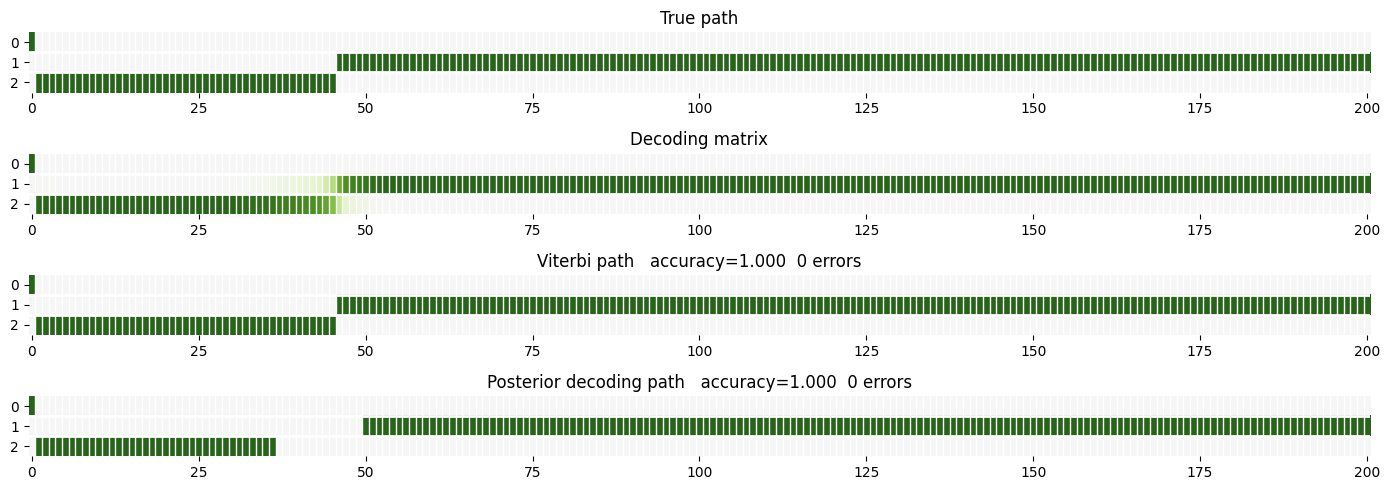

In [18]:
s = 0
(k, g0, g1) = true_tbl[s]
(logPv, logPf, logPb, D, vpi, dpi, v_nF, v_acc, d_nF, d_acc) = results[s]

visualize(true_pi[s], D, vpi, dpi)

Some observations:

1. In general, inferences are pretty accurate. Sequence 0 is an example where Viterbi correctly infers the switch point in the chimera. As I saw in the synthetic controls, the Decoding matrix shows how confidence decreases around the switch point, because the exact point of the switch is difficult to infer from composition. When Viterbi makes errors, it typically makes errors around the exact switch point, and the decoding path typically avoids most of those errors by not making calls where it's uncertain.

2. sequence 8 is an example where the sequence around 100-120 just happens to be AT-rich, even though it was generated by the GC-rich state 1. Both Viterbi and decoding make several errors there.

3. sequence 13 has the shortest segment (24). This isn't quite long enough to detect. Viterbi mislabels it and makes 24 errors.  The decoding matrix knows the inference is uncertain, and this lack of confidence allows posterior decoding to avoid making errors. I saw this effect of short segments on the postive controls too.



## 4. suggest a better HMM, and a better approach altogether

As noted when I did the positive controls, the HMM allows any sequence of segments, including just a single segment (with no switch point at all) and more than two segments (with more than one switch point). The actual data sequences always consist of exactly two segments with exactly one switch point. I can capture this better, and relatively easily, if I make an HMM with separate paths for the g0|g1 order and the g1|g0 order. My HMM would have 4 main states. State 1 and 3 would be GC-rich AluminumJesus composition, states 2 and 4 AT-rich T4 composition. State 0 would start in either 1 or 2. All these states have self-loops, but aside from that state 1 can only go to 4, and 4 can only end; state 2 can only go to 3, and 3 can only end. This HMM then always generates exactly two segments, in either order, with exactly one switch point between the two compositions.

That still leaves the problem that the segment length distributions generated by HMM states with self-transitions is geometric, and the HMM generates a variable-length sequence whereas the data are always fixed-length sequences of length 200. It is probably more appropriate to assume that the switch point is uniformly distributed, as we did with the motif finding problem last week. This problem is so simple that we don't really need an HMM at all. We can write down $P(x, k, g \mid \theta)$ for the probability of the observed sequence given that the switch point is at position $k$, starting with genome $g$, so $x_1..x_{k-1}$ are generated by genome $g$'s composition and $x_k..x_L$ are generated by the other genome's composition.  

In [19]:
%load_ext watermark
%watermark -v -m -p numpy,jupyter

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.26.0

numpy  : 2.1.0
jupyter: 1.0.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 23.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

